# RNN training attempt 01

For this first attempt, we'll use the feedforward encoding scheme as a starting point just to save time. We'll revert it back to the unflattened grid form to make it suitable for RNN training.

## Setup

In [245]:
# First mount your Google drive
from google.colab import drive
drive.mount('/content/gdrive')

# We'll use the note/chord encodings from simple feedforward as a starting point,
# so the root folder is set to simple-feedforward
root_path = 'gdrive/My Drive/Colab Notebooks/Thesis/simple-feedforward' # change this if needed

# Imports
import os
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import softmax

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load data

### Import from simple-feedforward

In [246]:
# Load encoded notes and chords
encoded_notes_path = os.path.join(root_path, "encoded_notes.npy")
encoded_chords_path = os.path.join(root_path, "encoded_chords.npy")
encoded_notes = np.load(encoded_notes_path)
encoded_chords = np.load(encoded_chords_path)

# Load song names
song_names_path = os.path.join(root_path, "song_names.pkl")
opened_file = open(song_names_path, "rb")
song_names = pkl.load(opened_file)
opened_file.close()

num_hooks = len(song_names)
print(f"Loaded data. Number of 8-bar hooks: {num_hooks}")

Loaded data. Number of 8-bar hooks: 3448


### Reshape into 3D tensors

In [247]:
NOTE_ONE_HOT_VECTOR_LENGTH = 38
CHORD_ONE_HOT_VECTOR_LENGTH = 32
NUM_16_NOTES_IN_8_BARS = 128

encoded_notes = encoded_notes.reshape((num_hooks, NOTE_ONE_HOT_VECTOR_LENGTH, NUM_16_NOTES_IN_8_BARS), order='F')
encoded_chords = encoded_chords.reshape((num_hooks, CHORD_ONE_HOT_VECTOR_LENGTH, NUM_16_NOTES_IN_8_BARS), order='F')

print(encoded_notes.shape)
print(encoded_chords.shape)

(3448, 38, 128)
(3448, 32, 128)


### Stack the melody and chords into one big tensor

Each timestep is represented as two one-hot vectors on top of each other, with a combined length of 70 (38 + 32). Notes are stacked on top of chords.

In [248]:
encoded_stack = np.concatenate((encoded_notes, encoded_chords), axis=1)
print(encoded_stack.shape)

(3448, 70, 128)


## Set up Music21 dev environment

### Import and install necessary packages

In [249]:
import music21
from IPython.display import Image, Audio

print("updating apt-get...")
!apt-get update > /dev/null

# enables music21 to render images of musical notes
print("\ninstalling lilypond...")
!apt-get install lilypond > /dev/null
#!apt-get install lilypond

# converts midi files to wav files into order to play them
print("installing fluidsynth...")
!apt-get install fluidsynth > /dev/null
#!apt-get install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

!fluidsynth --version
!lilypond --version

updating apt-get...

installing lilypond...
installing fluidsynth...
done!
FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

FluidSynth 1.1.9
GNU LilyPond 2.18.2

Copyright (c) 1996--2012 by
  Han-Wen Nienhuys <hanwen@xs4all.nl>
  Jan Nieuwenhuizen <janneke@gnu.org>
  and others.

This program is free software.  It is covered by the GNU General Public
License and you are welcome to change it and/or distribute copies of it
under certain conditions.  Invoke as `lilypond --warranty' for more
information.



These functions will make it easy to show and play back Music21 streams

In [250]:
# Display the music score
def show(music):
    display(Image(str(music.write('lily.png'))))

# Play the music at a user-specified bpm, or 120 if no bpm specified
def play(music, bpm=120):
    s = music21.stream.Stream()
    s.append(music21.tempo.MetronomeMark(number=bpm))
    s.append(music)
    filename = s.write('mid')
    !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
    display(Audio(filename + '.wav'))

### Translate encoded notes into a Music21 stream

In [251]:
C3_MIDI_VAL = 48

# Given a flattened notes encoding vector, return the one-hot vector at a particular
# timestep (0-indexed, so basically the column number of the 2D representation)
def get_note_one_hot(encoding, timestep):
    start_idx = timestep * NOTE_ONE_HOT_VECTOR_LENGTH
    end_idx = start_idx + NOTE_ONE_HOT_VECTOR_LENGTH
    return encoding[start_idx:end_idx]

# Given a one-hot encoding of a note, return the MIDI value of that note, or 0
# if the note encodes a hold
def decode_note_one_hot(one_hot):
    idx = np.argmax(one_hot)
    if idx == 0:
        return 0
    else:
        return idx + C3_MIDI_VAL - 1

# Given an encoding of a melody, return a Music21 stream representing that melody
def translate_notes(encoding, num_timesteps=NUM_16_NOTES_IN_8_BARS):
    # Initialize music21 stream
    s = music21.stream.Part()

    # First, move timestep i to the first note in the melody
    i = 0
    while i < num_timesteps:
        one_hot = get_note_one_hot(encoding, i)
        note_val = decode_note_one_hot(one_hot)
        if note_val != 0:
            break
        else:
            i += 1
        
    # Create a beginning rest note of the appropriate length
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(i / 4)
        s.append(rest)

    # Add all the notes. timestep i always represents the start of a note, or
    # 1 step past the end of the hook
    while i < num_timesteps:
        one_hot = get_note_one_hot(encoding, i)
        note_val = decode_note_one_hot(one_hot)

        # Scan for the next note (or to the end of the hook) to determine
        # the note's duration
        j = i + 1
        while j < num_timesteps:
            one_hot_lookahead = get_note_one_hot(encoding, j)
            note_lookahead = decode_note_one_hot(one_hot_lookahead)
            if note_lookahead != 0:
                break
            else:
                j += 1
        
        # Create the note and add to stream
        note = music21.note.Note(note_val)
        note.duration = music21.duration.Duration((j - i) / 4)
        s.append(note)

        # Move timestep to the next note (or 1 past end of hook)
        i = j

    # Return the stream
    return s

### Translate encoded chords into a Music21 stream



In [252]:
# Re-create the mapping between chords and one-hot indices

allowed_chords = [
    '00-dim',
    '00-maj',
    '00-min',
    '01-dim',
    '01-maj',
    '02-dim',
    '02-maj',
    '02-min',
    '03-dim',
    '03-maj',
    '03-min',
    '04-dim',
    '04-maj',
    '04-min',
    '05-maj',
    '05-min',
    '06-dim',
    '06-maj',
    '07-dim',
    '07-maj',
    '07-min',
    '08-dim',
    '08-maj',
    '09-dim',
    '09-maj',
    '09-min',
    '10-maj',
    '10-min',
    '11-dim',
    '11-maj',
    '11-min'
]

def create_converted_chord_to_idx_map():
    map = []
    start_idx = 1 # start at 1 since idx 0 is reserved for holds
    for chord_str in allowed_chords:
        map.append([chord_str, start_idx])
        start_idx += 1
    return map

converted_chord_to_idx_map = create_converted_chord_to_idx_map()
for item in converted_chord_to_idx_map:
    print(item)

['00-dim', 1]
['00-maj', 2]
['00-min', 3]
['01-dim', 4]
['01-maj', 5]
['02-dim', 6]
['02-maj', 7]
['02-min', 8]
['03-dim', 9]
['03-maj', 10]
['03-min', 11]
['04-dim', 12]
['04-maj', 13]
['04-min', 14]
['05-maj', 15]
['05-min', 16]
['06-dim', 17]
['06-maj', 18]
['07-dim', 19]
['07-maj', 20]
['07-min', 21]
['08-dim', 22]
['08-maj', 23]
['09-dim', 24]
['09-maj', 25]
['09-min', 26]
['10-maj', 27]
['10-min', 28]
['11-dim', 29]
['11-maj', 30]
['11-min', 31]


In [253]:
C2_MIDI_VAL = 36

# Given a flattened chord encoding vector, return the one-hot vector at a particular
# timestep (0-indexed, so basically the column number of the 2D representation)
def get_chord_one_hot(encoding, timestep):
    start_idx = timestep * CHORD_ONE_HOT_VECTOR_LENGTH
    end_idx = start_idx + CHORD_ONE_HOT_VECTOR_LENGTH
    return encoding[start_idx:end_idx]

# Given the string form of a chord (like '00-maj'), return the [semi, chord_class]
# form
def str_to_converted_chord(str_form):
    semi = int(str_form[0:2])
    chord_class = str_form[3:6]
    return [semi, chord_class]

# Given a one-hot encoding of a chord, return the [semitone, class] form of the
# chord, or 0 if the encoding denotes a hold
def decode_chord_one_hot(one_hot):
    idx = np.argmax(one_hot)
    if idx == 0:
        return 0

    str_form = ''
    map_lookup_successful = False
    for item in converted_chord_to_idx_map:
        if item[1] == idx:
            str_form = item[0]
            map_lookup_successful = True
            break

    if not map_lookup_successful:
        raise Exception("Error when converting one-hot idx to str_form!")
    else:
        return str_to_converted_chord(str_form)

# Given a chord in the form [semitone, class], return a list of the 3 MIDI
# notes comprising the triad. All chords in open-form
def chord_to_MIDI_list(chord):
    semi = chord[0]
    chord_class = chord[1]

    low = chord[0] + C2_MIDI_VAL
    mid = low + 7
    if chord_class == 'dim':
        mid -= 1
    hi = low + 16
    if chord_class == 'dim' or chord_class == 'min':
        hi -= 1
    
    return [low, mid, hi]


# Given an encoding of a chord sequence, return a Music21 stream representing
# that chord sequence
def translate_chords(encoding, num_timesteps=NUM_16_NOTES_IN_8_BARS):
    # Initialize music21 stream
    s = music21.stream.Part()
    s.append(music21.clef.BassClef())

    # First, move timestep i to the first chord in the sequence
    i = 0
    while i < num_timesteps:
        one_hot = get_chord_one_hot(encoding, i)
        chord_item = decode_chord_one_hot(one_hot)
        if chord_item != 0:
            break
        else:
            i += 1
        
    # Create a beginning rest of the appropriate length
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(i / 4)
        s.append(rest)

    # Add all the chords. timestep i always represents the start of a chord, or
    # 1 step past the end of the hook
    while i < num_timesteps:
        one_hot = get_chord_one_hot(encoding, i)
        chord_item = decode_chord_one_hot(one_hot)

        # Scan for the next chord (or to the end of the hook) to determine
        # the chord's duration
        j = i + 1
        while j < num_timesteps:
            one_hot_lookahead = get_chord_one_hot(encoding, j)
            chord_lookahead = decode_chord_one_hot(one_hot_lookahead)
            if chord_lookahead != 0:
                break
            else:
                j += 1
        
        # Create the chord and add to stream
        notes_in_chord = chord_to_MIDI_list(chord_item)
        chord = music21.chord.Chord(notes_in_chord)
        chord.duration = music21.duration.Duration((j - i) / 4)
        s.append(chord)

        # Move timestep to the next note (or 1 past end of hook)
        i = j

    # Return the stream
    return s

### Combine the two streams

In [254]:
# Given a notes stream and chords stream, create a 2-part stream
def combine_streams(notes_stream, chords_stream):
    master_score = music21.stream.Score()
    master_score.append(notes_stream)
    master_score.append(chords_stream)
    master_score[1].offset = 0.0
    return master_score


## Sanity check: check if your reshaping and concatenation worked as expected

Song name: Hey Soul Sister


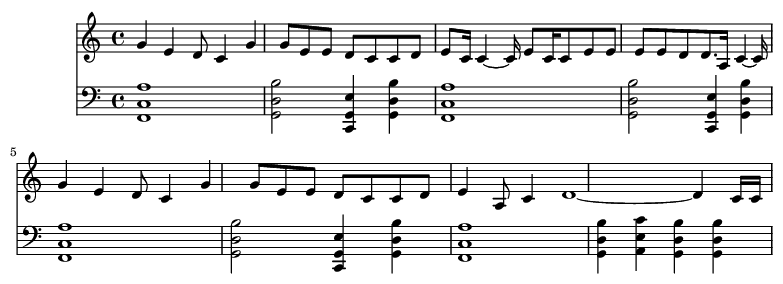

In [255]:
def sanity_check_reshape():
    # song index
    idx = 414

    # decode the stack at the given idx
    a = NOTE_ONE_HOT_VECTOR_LENGTH
    b = NOTE_ONE_HOT_VECTOR_LENGTH + CHORD_ONE_HOT_VECTOR_LENGTH
    melody = encoded_stack[idx, 0:a, :].flatten('F') # these lines are tricky
    chords = encoded_stack[idx, a:b, :].flatten('F')

    # translate melody/chords and generate score
    translated_melody = translate_notes(melody)
    translated_chords = translate_chords(chords)
    score = combine_streams(translated_melody, translated_chords)

    # display results
    print(f"Song name: {song_names[idx]}")
    show(score)
    play(score)

sanity_check_reshape()

Things look good!

## Divide up data into sequences for RNN feeding

In [256]:
# Sequence length is 1 greater than the actual length of your input/output sequences
# (since input and output are offset by 1 timestep). Don't get confused
SEQUENCE_LENGTH = 64

# Transpose the grid representation such that ROWS denote timesteps rather than COLS
encoded_stack_transposed = np.transpose(encoded_stack, (0, 2, 1))
print(f"Transposed encoded stack shape: {encoded_stack_transposed.shape}")

input_sequences = []
output_sequences = []
song_names_for_sequences = []

for i in range(len(encoded_stack)):
    num_shifts = NUM_16_NOTES_IN_8_BARS - SEQUENCE_LENGTH + 1
    for j in range(num_shifts):
        seq_start = j
        seq_end = j + SEQUENCE_LENGTH
        input_sequence = encoded_stack_transposed[i, seq_start:seq_end-1, :]
        output_sequence = encoded_stack_transposed[i, seq_start+1:seq_end, :]
        input_sequences.append(input_sequence)
        output_sequences.append(output_sequence)
        song_names_for_sequences.append(song_names[i])
    
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)
print(f"Input sequences shape: {input_sequences.shape}")
print(f"Output sequences shape: {output_sequences.shape}")
print(f"Number of song names listed for sequences: {len(song_names_for_sequences)}")

Transposed encoded stack shape: (3448, 128, 70)
Input sequences shape: (224120, 63, 70)
Output sequences shape: (224120, 63, 70)
Number of song names listed for sequences: 224120


## Define and compile model

In [257]:
INPUT_LENGTH = 70
OUTPUT_LENGTH = INPUT_LENGTH

model = keras.Sequential([
    layers.Input(shape=(SEQUENCE_LENGTH - 1, INPUT_LENGTH)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.Dense(OUTPUT_LENGTH)
])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])


Sanity checking array dimensions

In [258]:
example_idx = 0
input_example = input_sequences[example_idx].reshape(1, SEQUENCE_LENGTH - 1, INPUT_LENGTH)
print(input_example.shape)

output_example = model(input_example)
print(output_example)

(1, 63, 70)
tf.Tensor(
[[[-0.00326877  0.00199157 -0.00323837 ...  0.00021626  0.00229536
    0.00069304]
  [ 0.00345362  0.00617162 -0.01443458 ... -0.00538037  0.00094518
   -0.00156666]
  [ 0.01309606  0.00766688 -0.02314081 ... -0.00796981  0.00140805
   -0.01085918]
  ...
  [ 0.04879544  0.00710063 -0.10463741 ... -0.00041636 -0.03464323
   -0.08443464]
  [ 0.05211938  0.00635957 -0.10792441 ...  0.00315327 -0.03612314
   -0.08473407]
  [ 0.05419015  0.00814409 -0.11307703 ...  0.00196335 -0.03693101
   -0.08210795]]], shape=(1, 63, 70), dtype=float32)


## Try out the untrained model

### Define function for generating an 8-bar hook with your model using a given song index as input

In [259]:
# Given a sequence index, return the corresponding 127-long input sequence reshaped to be
# model-friendly
def get_input(idx):
    # Display the score and .wav file for the input sequence along with the song name
    print(f"Using input seed sequence from {song_names_for_sequences[idx]}:")
    input_sequence = input_sequences[idx]
    a = NOTE_ONE_HOT_VECTOR_LENGTH
    b = NOTE_ONE_HOT_VECTOR_LENGTH + CHORD_ONE_HOT_VECTOR_LENGTH
    melody = input_sequence[:, 0:a].flatten()
    chords = input_sequence[:, a:b].flatten()
    translated_melody = translate_notes(melody, num_timesteps=SEQUENCE_LENGTH-1)
    translated_chords = translate_chords(chords, num_timesteps=SEQUENCE_LENGTH-1)
    score = combine_streams(translated_melody, translated_chords)
    show(score)
    play(score)

    # Return the input sequence with the right dimensions
    input_sequence = input_sequences[idx].reshape(1, SEQUENCE_LENGTH - 1, INPUT_LENGTH)
    return input_sequence

# Given an input sequence of timesteps, predict the indexes of the note and chord
# for the next timestep. Temperature dictates how random the sampling is (close to 0
# is "harder" distribution, 1 is default softmax, >1 is "softer" i.e. closer to uniform)
def predict_next_timestep(input, temperature):
    # Only use the last timestep prediction
    output = model(input)
    output = output[:, -1, :]

    # Apply temperature to logits and softmax note and chord vectors
    a = NOTE_ONE_HOT_VECTOR_LENGTH
    b = NOTE_ONE_HOT_VECTOR_LENGTH + CHORD_ONE_HOT_VECTOR_LENGTH
    softmax_note_vect = softmax(output[0, 0:a] / temperature)
    softmax_chord_vect = softmax(output[0, a:b] / temperature)

    # Sample from softmaxes to predict the next note/chord
    note_sample = np.random.multinomial(1, softmax_note_vect)
    chord_sample = np.random.multinomial(1, softmax_chord_vect)
    pred_note_idx = np.argmax(note_sample)
    pred_chord_idx = np.argmax(chord_sample) + NOTE_ONE_HOT_VECTOR_LENGTH

    return pred_note_idx, pred_chord_idx

# Given a sequence index and sampling temperature, use the corresponding song as input for your RNN and
# generate a user-defined number of timesteps by repeatedly re-feeding the sequence
# (offset by one timestep, and with the newly predicted timestep appended at the end)
# until 8 bars have been generated
def generate_hook(idx, temperature):
    # Setup. Timesteps are now represented as rows (don't get confused)
    generated_hook = np.zeros((NUM_16_NOTES_IN_8_BARS, INPUT_LENGTH))
    input = get_input(idx)
    sequence = input

    # For all timesteps in an 8-bar hook...
    for i in range(NUM_16_NOTES_IN_8_BARS):
        # Fill in the predicted one-hot entries for note and chord at current timestep
        (pred_note_idx, pred_chord_idx) = predict_next_timestep(sequence, temperature)
        generated_hook[i, pred_note_idx] = 1
        generated_hook[i, pred_chord_idx] = 1

        # Shift the sequence one timestep, including the new predicted step
        predicted_vect = generated_hook[i, :].reshape(1, 1, -1)
        sequence = np.concatenate((sequence[:, 1:, :], predicted_vect), axis=1)

    # Display the score and audio for the generated hook
    print("Generated output:")
    a = NOTE_ONE_HOT_VECTOR_LENGTH
    b = NOTE_ONE_HOT_VECTOR_LENGTH + CHORD_ONE_HOT_VECTOR_LENGTH
    melody = generated_hook[:, 0:a].flatten()
    chords = generated_hook[:, a:b].flatten()
    translated_melody = translate_notes(melody)
    translated_chords = translate_chords(chords)
    score = combine_streams(translated_melody, translated_chords)
    show(score)
    play(score)

# testing area
def test_model(temperature):
    random_idx = np.random.randint(0, len(input_sequences))
    generate_hook(random_idx, temperature)

test_model(0.2)

Output hidden; open in https://colab.research.google.com to view.

## Train your model (skip this step if you just want to load a pre-trained model)

In [260]:
print(input_sequences.shape)
print(output_sequences.shape)
# model.fit(input_sequences, output_sequences, epochs=10) # comment this out if using pre-trained model

(224120, 63, 70)
(224120, 63, 70)


## Save model

In [261]:
# model.save('saved_model.h5') # comment this out if loading pre-trained

Download this from the Colab content folder, rename to whatever you want, then reupload to Google Drive

## Load model (change the file path to whatever .h5 file you want to load)

In [262]:
# change this path if needed
saved_model_path = 'gdrive/My Drive/Colab Notebooks/Thesis/rnn-attempt-01/rnn01_publication.h5'

# load model
model = keras.models.load_model(saved_model_path)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 63, 64)            34560     
                                                                 
 lstm_3 (LSTM)               (None, 63, 64)            33024     
                                                                 
 dense_1 (Dense)             (None, 63, 70)            4550      
                                                                 
Total params: 72,134
Trainable params: 72,134
Non-trainable params: 0
_________________________________________________________________


## Save schematic of model

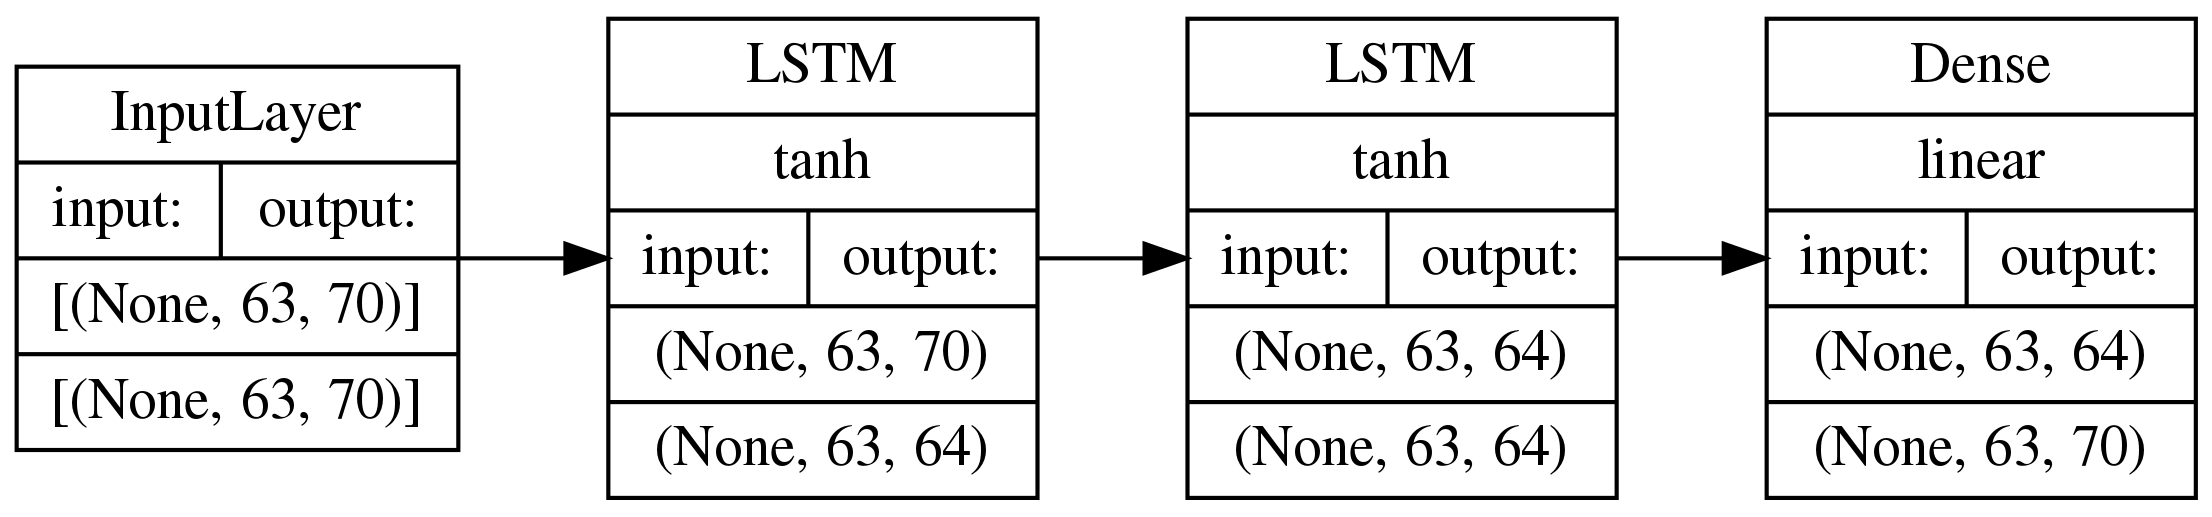

In [263]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False, rankdir="LR", dpi=300, show_layer_activations=True)

## Test it out!

In [276]:
test_model(0.15)

Output hidden; open in https://colab.research.google.com to view.